**Import the required libraries**

melakukan import library yang dibutuhkan


In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from spellchecker import SpellChecker
from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer
from scipy.sparse import csr_matrix

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [149]:
from google.colab import files
upload = files.upload()

Saving anime_reviews-mal(2).csv to anime_reviews-mal(2).csv


**Load dataset**

Load dataset menggunakan pandas, data label disini merupakan pernyataan apakah anime direkomendasikan untuk di tonton atau tidak, bukan mewakili sentiment pengguna, jadi akan dilakukan labeling kembali untuk sentiment berdasarkan comment

In [150]:
data = pd.read_csv('anime_reviews.csv', encoding='latin-1')
data.head()

,Username,Anime Title,Comment,Label,Created At
0,nicolem_animefan,Tomo-chan wa Onnanoko!,"8.5/10 +Funny, likeable couple with great chem...",Recommended,"Jul 2, 2023"
1,mashrafi75,Kimetsu no Yaiba: Katanakaji no Sato-hen,Very good but worst season between the three. ...,Recommended,"Jul 2, 2023"
2,mashrafi75,Vinland Saga Season 2,This is a Masterpiece. Season 1 becomes great ...,Recommended,"Jul 2, 2023"
3,mashrafi75,"""Oshi no Ko""",Manga reader here. Don't judge a book by its c...,Recommended,"Jul 2, 2023"
4,abxbxh,Angel Beats!,80% of the anime is trashy but the rest 20%: E...,Recommended,"Jul 2, 2023"


In [151]:
data = data.loc[:, 'Comment']
data = pd.DataFrame(data)

In [152]:
data.head()

,Comment
0,"8.5/10 +Funny, likeable couple with great chem..."
1,Very good but worst season between the three. ...
2,This is a Masterpiece. Season 1 becomes great ...
3,Manga reader here. Don't judge a book by its c...
4,80% of the anime is trashy but the rest 20%: E...


**Preprocessing Data**

Untuk mempersiapkan data teks agar siap digunakan, beberapa tahap preprocessing akan dilakukan, antara lain:

**2.1 Cleaning**
1. Pembersihan (Cleaning): Menghapus karakter-karakter yang tidak diinginkan seperti tanda baca, karakter khusus, atau URL yang tidak relevan.
2. Case Folding: Mengubah semua huruf dalam teks menjadi huruf kecil atau huruf besar. Tujuannya adalah untuk mengabaikan perbedaan kapitalisasi yang tidak relevan dalam analisis teks.

In [153]:
def clean_reviews(comment):
  # Convert comment to lower case
  comment = comment.lower()
  # Convert www.* or https?://* to URL
  comment = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',comment)
  # Remove numbers from text
  comment = re.sub(r"\d+", "", comment)
  # Replacing punctuation with spaces
  comment = comment.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  # Remove additional white spaces
  comment = re.sub('[\s]+', ' ', comment)
  return comment

In [154]:
data['Comment'] = data['Comment'].apply(lambda comment : clean_reviews(comment))
data['Comment'].values

data.head()

,Comment
0,funny likeable couple with great chemistry pl...
1,very good but worst season between the three a...
2,this is a masterpiece season becomes great aft...
3,manga reader here don t judge a book by its co...
4,of the anime is trashy but the rest emotional...


**2.2 StopWords**

Stop words adalah kata-kata yang umumnya tidak memberikan informasi yang signifikan dalam konteks analisis teks atau pemrosesan bahasa alami. Kata-kata ini sering kali muncul secara berulang dalam suatu teks dan cenderung memiliki frekuensi tinggi di dalamnya. Contoh stop words dalam bahasa Inggris termasuk "the", "is", "in", "and", "of", "it", "to", dan sebagainya.

In [155]:
# Create StopWords
with open('stopwords.txt', 'r') as fl:
  stop_words = fl.readline()
  stop_words = stop_words.split()

**2.3 Tokenizer**

Tokenizer merupakan proses untuk memecah teks menjadi kata-kata terpisah. Hal ini sangat berguna dalam memahami dan memproses teks secara lebih efektif. Setelah proses tokenisasi, kata-kata dari teks akan difilter untuk mencari kata-kata yang tidak termasuk dalam daftar stop words dan memiliki panjang lebih dari 2 kata. Selanjutnya, akan dilakukan pencarian kata dasar dari kata-kata yang telah difilter menggunakan metode SnowballStemmer. Tujuan dari langkah-langkah ini adalah untuk menghilangkan kata-kata yang tidak relevan dan mengubah kata-kata menjadi bentuk dasarnya dalam analisis teks.

In [156]:
# Create stemmer
stemmer = SnowballStemmer('english')
# Object SpellChecker
spell = SpellChecker()

# Tokenizer
def tokenizer_comment(comment):
  words = word_tokenize(comment)
  tokens = []
  for word in words:
    if len(word) > 2 and word not in stop_words:
      # Correcting typos
      # spell.correction(word), this process is very long so I skipped it
      # Find the root word
      word = stemmer.stem(word)
      tokens.append(word)
  return " ".join(tokens)

In [157]:
data['Comment'] = data['Comment'].apply(tokenizer_comment)

In [ ]:
data.head(10)

,Comment
0,review origin written himouto umaru chan anim ...
1,idk whi part exist when they can relea one sea...
2,wait this underr show with amaz comedi but was...
3,anim pretti averag there are some decent backg...
4,both girl repr the music piec liz and the blue...
5,sincer yearn that would enjoy this movi more t...
6,episod episod mayor hartford connecticut heard...
7,did come here after finish spi famili and got ...
8,you have minut free one afternoon there are wo...
9,this seri all kind bad dumpster fire level bad...


**Vectorization**

Vectorisasi adalah proses mengubah teks atau data non-numerik menjadi representasi numerik. Untuk melihat kata-kata dengan bobot TF-IDF tertinggi,dan melakukan visulaisasi

In [158]:
# Defining Vectorizer object
vectorizer_tfidf = TfidfVectorizer(min_df=0.01, max_df=0.6)

# Vectorisation process on text data
x = vectorizer_tfidf.fit_transform(data['Comment'].values)

Mengakes jumlah artikel dan feature dalam dataset

In [159]:
# Get TF-IDF weight
tfidf_weights = x.toarray()

# Get a list of features/column names
feature_names = vectorizer_tfidf.get_feature_names_out()

dimensions = x.get_shape()
print(f"Jumlah artikel = {dimensions[0]}")
print(f"Jumlah fitur   = {dimensions[1]}")

Jumlah artikel = 17550
Jumlah fitur   = 1847


Melihat kata - kata dengan bobot TF-IDF tertinggi

In [161]:
content1, content2 = [], []

for n in range(dimensions[0]):
    # Convert sparse matrix row by row
    row = x.getrow(n).toarray()[0].ravel()
    # Get top values and its indexes
    top_ten_indices = row.argsort()[-1]
    top_ten_values = row[row.argsort()[-1]]
    # Identify the highest TFIDF value and word #
    highestTFIDFword = feature_names[top_ten_indices]
    highestTFIDFvalue = top_ten_values
    top1word = {'nomor artikel': n+1, 'nilai TFIDF': highestTFIDFvalue,
                'top word': highestTFIDFword}
    content1.append(top1word)
    content2.append(highestTFIDFword)

# Calculate the Frequency of the word with the largest weight
content2 = np.asarray(content2)
words, n = np.unique(content2, return_counts=True)

# Convert to DataFrame then sort descendingly
# Then select 20 words with the largest frequency
words_data = pd.DataFrame({
    'Kata': words,
    'Banyak': n
}).sort_values(by='Banyak', ascending=False).head(20)
words_data

,Kata,Banyak
1269,season,582
967,movi,524
1315,show,395
698,her,240
565,film,240
1287,seri,209
1300,she,184
622,game,174
792,isekai,165
168,bocchi,154


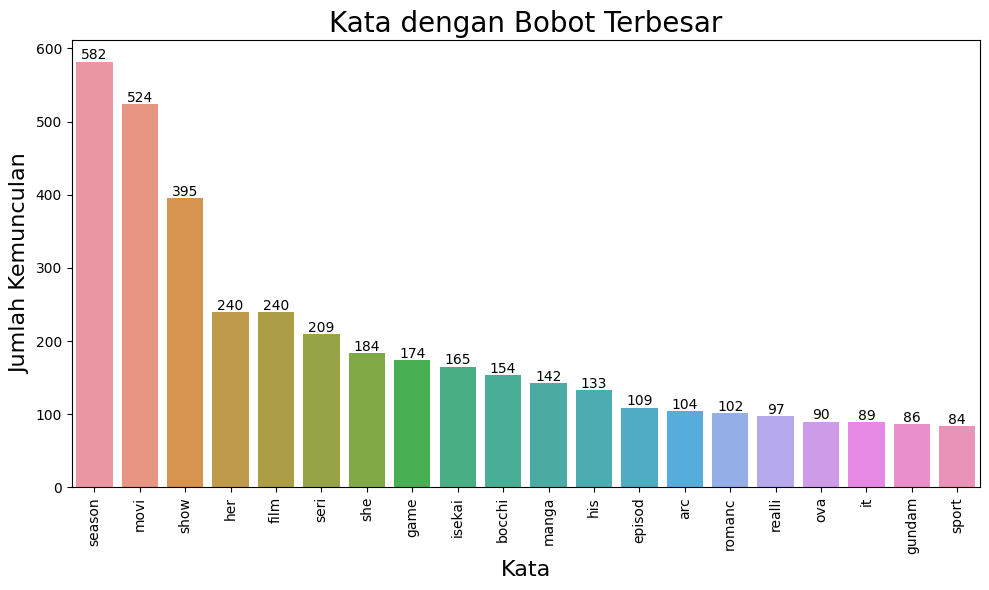

In [162]:
plt.figure(figsize=(10, 6))  # Mengubah ukuran gambar

# Plotting Barplot
sns.barplot(x=words_data['Kata'], y=words_data['Banyak'])

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(words_data['Banyak'].tolist()):
    plt.text(i, v + 3, str(v), fontsize=10, ha='center')

# Mengatur judul dan label sumbu
plt.title('Kata dengan Bobot Terbesar', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Kata', fontsize=16)
plt.ylabel('Jumlah Kemunculan', fontsize=16)

plt.tight_layout()  # Mengatur tata letak plot
plt.show()

**Write Data Anime Reviews to CSV**

menulis data hasil cleaning ke file csv menggunakan pandas

In [165]:
df = pd.DataFrame(data)
df.to_csv('cleaned_reviews.csv', index=False)

In [166]:
clean = pd.read_csv('cleaned_reviews.csv')
clean.head(10)

,Comment
0,funni likeabl coupl with great chemistri plot ...
1,veri good but worst season between the three a...
2,this masterpiec season becom great after the f...
3,manga reader here don judg book it cover and d...
4,the anim trashi but the rest emot moment and s...
5,the isekai that isn isekai the stori set fanta...
6,the main charact discord mod fat and get heavi...
7,here review this anim stori the stori about ma...
8,will honest this anim start with the have psyc...
9,stone from second season was downgrad but stil...
